<a href="https://colab.research.google.com/github/hugeinteger/InterFaceGAN/blob/master/colab_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Before running make sure GPU usage is enabled.
Runtime->Change runtime type->GPU

In [1]:
!git clone https://github.com/ShenYujun/InterFaceGAN.git InterFaceGAN
import os
os.chdir("InterFaceGAN")

Cloning into 'InterFaceGAN'...
remote: Enumerating objects: 171, done.
remote: Counting objects: 100% (171/171), done.
remote: Compressing objects: 100% (131/131), done.
remote: Total 171 (delta 48), reused 153 (delta 36), pack-reused 0
Receiving objects: 100% (171/171), 2.07 MiB | 15.22 MiB/s, done.
Resolving deltas: 100% (48/48), done.


Necessary imports

In [0]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
%matplotlib inline

Create necessary directories.

In [0]:
!mkdir data
!mkdir results
!mkdir saved_edits

Mount google drive

In [2]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


Copy pretrained models from my google drive.</br>
StyleGAN - https://drive.google.com/open?id=1uka3a1noXHAydRPRbknqwKVGODvnmUBX </br>
ProGAN - https://drive.google.com/open?id=0B4qLcYyJmiz0NHFULTdYc05lX0U

In [0]:
# StyleGAN model pre-trained on celebahq dataset
!cp '/gdrive/My Drive/StyleGAN/networks/karras2019stylegan-celebahq-1024x1024.pkl' models/pretrain

# StyleGAN model pre-trained on ffhq dataset
!cp '/gdrive/My Drive/StyleGAN/networks/karras2019stylegan-ffhq-1024x1024.pkl' models/pretrain

# ProGAN model pre-trained on celebahq
!cp '/gdrive/My Drive/ProgressiveGAN/networks/tensorflow-version/karras2018iclr-celebahq-1024x1024.pkl' models/pretrain

Generate images and latent codes.
Below calls could cause CuDNN version errors, but they disappear after re-runs.

In [15]:
NUM = 3 # number of images to be generated
!rm -rf data/stylegan_celebahq
!python generate_data.py -m stylegan_celebahq -o data/stylegan_celebahq -n '$NUM'
!rm -rf data/stylegan_ffhq
!python generate_data.py -m stylegan_ffhq -o data/stylegan_ffhq -n '$NUM'
!rm -rf data/pggan_celebahq
!python generate_data.py -m pggan_celebahq -o data/pggan_celebahq -n '$NUM'


[2019-09-06 19:46:52,195][INFO] Initializing generator.
[2019-09-06 19:46:52,519][INFO] Loading pytorch model from `models/pretrain/stylegan_celebahq.pth`.
[2019-09-06 19:46:52,817][INFO] Successfully loaded!
[2019-09-06 19:46:52,818][INFO]   `lod` of the loaded model is 0.0.
[2019-09-06 19:46:55,227][INFO] Preparing latent codes.
[2019-09-06 19:46:55,227][INFO]   Sample latent codes randomly.
[2019-09-06 19:46:55,227][INFO] Generating 3 samples.
[2019-09-06 19:46:55,856][INFO] Saving results.


Visualize created images.

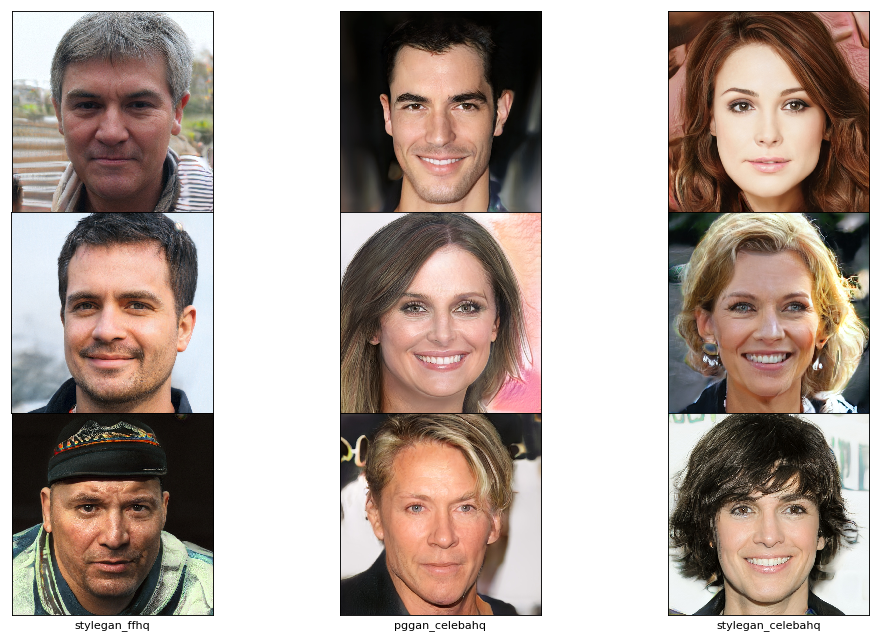

In [16]:
cols = 3 # == number of models
rows = NUM # == number of generated images

plt.figure(figsize=(15, 10), dpi=80)
directory = sorted(os.listdir('data'))
i = 0
for each in directory:
    currentFolder = 'data/' + each
    j = 0
    for fullpath in sorted(glob.glob(currentFolder + "/*.jpg")):
        img=mpimg.imread(fullpath)
        plt.subplot(rows, cols, cols * j + i + 1)
        plt.xticks([])
        plt.yticks([])
        #plt.aspect('equal')
        plt.subplots_adjust(hspace=0)
        plt.xlabel(each)
        plt.imshow(img)
        j = j + 1
    i = i + 1

plt.savefig('saved_edits/' + generated_imgs + '.jpg')


Usefull functions for edits/visualisations

In [0]:
import re

def edit(model, boundary, latent):
  !rm -rf results/'$model'_'$boundary'_editing
  #!python edit.py -h
  !python edit.py  -m '$model' -b boundaries/'$model'_'$boundary'_boundary.npy -i data/'$model'/'$latent'.npy -o results/'$model'_'$boundary'_editing

def show(model, prefix):
  plt.figure(figsize=(18, 18))
  #ig = plt.figure()
  #ig.suptitle(model)
  k = 1
  for currentFolder in sorted(glob.glob("results/" + model + "*")):
      boundary = re.search('results/' + model + '_(.+?)_editing', currentFolder)
      if boundary:
        boundary = boundary.group(1)
      else:
        continue
      j = 0
      for fullpath in sorted(glob.glob(currentFolder + "/" + prefix + "_*.jpg")):
          img = mpimg.imread(fullpath)
          plt.subplot(9, 10, k)
          plt.xticks([])
          plt.yticks([])
          plt.subplots_adjust(wspace = 0, hspace=0)
          if j == 0:
            plt.ylabel(boundary)
          plt.imshow(img)
          k = k + 1
          j = j + 1
  #lt.tight_layout()
  plt.savefig('saved_edits/' + model + '.jpg')

def edit_all(model, latent):
  boundaries = ["pose", "smile", "age", "age_c_gender", "age_c_eyeglasses", "gender", "eyeglasses", "eyeglasses_c_age", "eyeglasses_c_gender"]
  boundary_postfix = ""
  if 'w' == latent:
    boundary_postfix = "_" + latent
    boundaries = [boundary + boundary_postfix for boundary in boundaries]
  
  for boundary in boundaries:
    edit(model, boundary, latent)



Edit **StyleGAN FFHQ** images, choose an image to visualize edits for

In [0]:
edit_all('stylegan_ffhq', 'z')

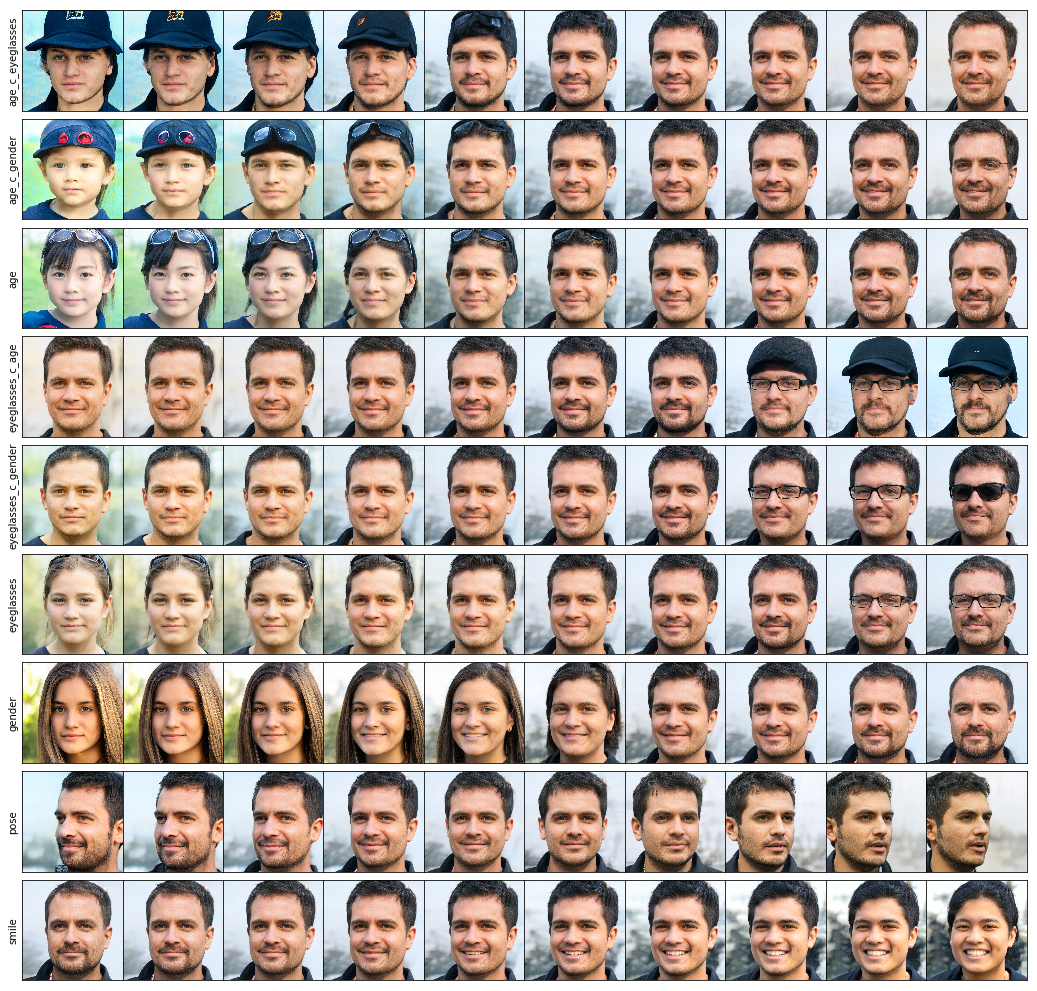

In [85]:
show('stylegan_ffhq', '000')